# Projects in Maths Modelling - ACM40960
## COVID-19 Detection using Radiography Images
### Ninad Thaker - 20202926

# Background

The first known case of a highly contagious disease caused by Severe Acute Respiatory Syndrome CoronaVirus 2 (SARS-CoV-2) was identified in Wuhan, China, in December 2019. World Health Organization (WHO) declared it a Public Emergenc of Global Scale or an Epidemic in January  2020. However, the disease kept spreading, and soon thousands deaths were reported. In February 2020, WHO named the disease as "COVID-19" and by March 2020, the disease was declard as a pandemic and has since then spread worldwide.

This project aims to train a machine learning model which can identify the presence of COVID-19 disease from the radiographic image data of patients, and also to visually highlight the areas containing the COVID scar tissue.

We will use 3 different types of images to train and test the accuracy of our model. Here, we have the pre-labeled image dataset containing Chest X-Rays of patients with COVID-19, Viral Pneumonia and the patients who are completely Normal for the reference. The data is available on kaggle. [1]

### SYSTEM CONFIGURATION
**Processor:** Intel Core i7-9750H\
**Memory:** 16 GB\
**Graphis Processor:** NVIDIA GTX 1660Ti - 6 GB\
**OS:** Windows 10 64-bit\
**Conda Version:** 4.10.1\
**Python Version:** 3.8\
**Tensorflow/Tensorflow-GPU Version:** 2.5.0\
**Keras Version:** 2.5.0

# Convolutional Neural Network
## Importing Packages

In the following code block we will import all the required packages from different libraries and we will also monitor the execution time.

In [1]:
# Importing timer for measuring total run time and model training time
from time import process_time

# Defining Start time
start_time = process_time()

# Importing default packages - os for path, garbage collection for memory management
import os, gc, glob

# Importing cv2 for image reading
import cv2

# Importing NumPy and Pandas for matrix, array and daraframe manipulation
import numpy as np
import pandas as pd

# Importing matplotlib and seaborn for image manipulation and plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import seaborn as sns

# Importing tensorflow and keras for CNN model training and testing
import tensorflow as tf
from tensorflow.keras import layers, models

import keras
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from keras.layers import Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizer_v2.adam import Adam as adam
from keras.utils.np_utils import to_categorical
from keras.applications import densenet

# Importing SKlearn for division of data, evaluation of models, reporting and labeling the images
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Preprocessing Image and Label Data

Since the image dataset is in folder called "Radiography", we will scan through the folder and all the 3 sub-folders (COVID, Normal, and Viral Pneumonia) in the Radiography folder to find all the images ending with extension ".png" and store their paths.

In [2]:
# Defining Paths for all the Images
imagePaths = []

# This for loop will iterate through the entire Radiography Directory and its sub directories
for dirname, _, filenames in os.walk('E:Radiography/'):
    
    # This for loop will iterate through all the files in the current sub directory
    for filename in filenames:
        
        # If the file extension of the current file is .png then add the file name to the image path list
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

Now that we have path of all the images, we resize, relabel and load the images into the main memory or RAM such that it can later be used for training and testing purpose.

In [3]:
# Defining labels for the image data
Data = []
Labels = []

# Defining dimension of the image
# CAUTION: DO NOT INCREASE THE SIZE OF THE IMAGE
#          Due to the size of the Memory(hardware limitation), the larger image size would result in CRASHING
resize = 150

# Defining a dictonary to provide proper names without actually modifying the files
categories = {'Viral Pneumonia': 'PNEUMONIA', 'Normal': 'NORMAL', 'COVID': 'COVID'}

# This for loop will iterate through the image path list
for imagePath in imagePaths:
    
    # Extract the label from the file
    label = imagePath.split(os.path.sep)[-2].split("/")[-1]
    
    # Read the image file
    image = cv2.imread(imagePath)
    
    # Change the color channel to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize the image
    image = cv2.resize(image, (resize, resize)) /255
    
    # Append image such that it is present in Memory for faster access
    Data.append(image)
    
    # Append label form the dictonary such that it is present in Memory for faster access
    Labels.append(categories[label])


In [4]:
# Identify the number of images found and stored using the Labels variable(Target Name)
print("Printing Number of Images for each Category...\n"
      '\nCOVID:',Labels.count('COVID'),
      '\nNORMAL:',Labels.count('NORMAL'),
      '\nPNEUMONIA:',Labels.count('PNEUMONIA'))

Printing Number of Images for each Category...

COVID: 3616 
NORMAL: 10192 
PNEUMONIA: 1345


# Visualization of Images

Perfect! We now have all the images from Radiography folder loaded in the RAM of size 150x150 each. Let's take a look at some random images to test the working of our resizing and relabelling

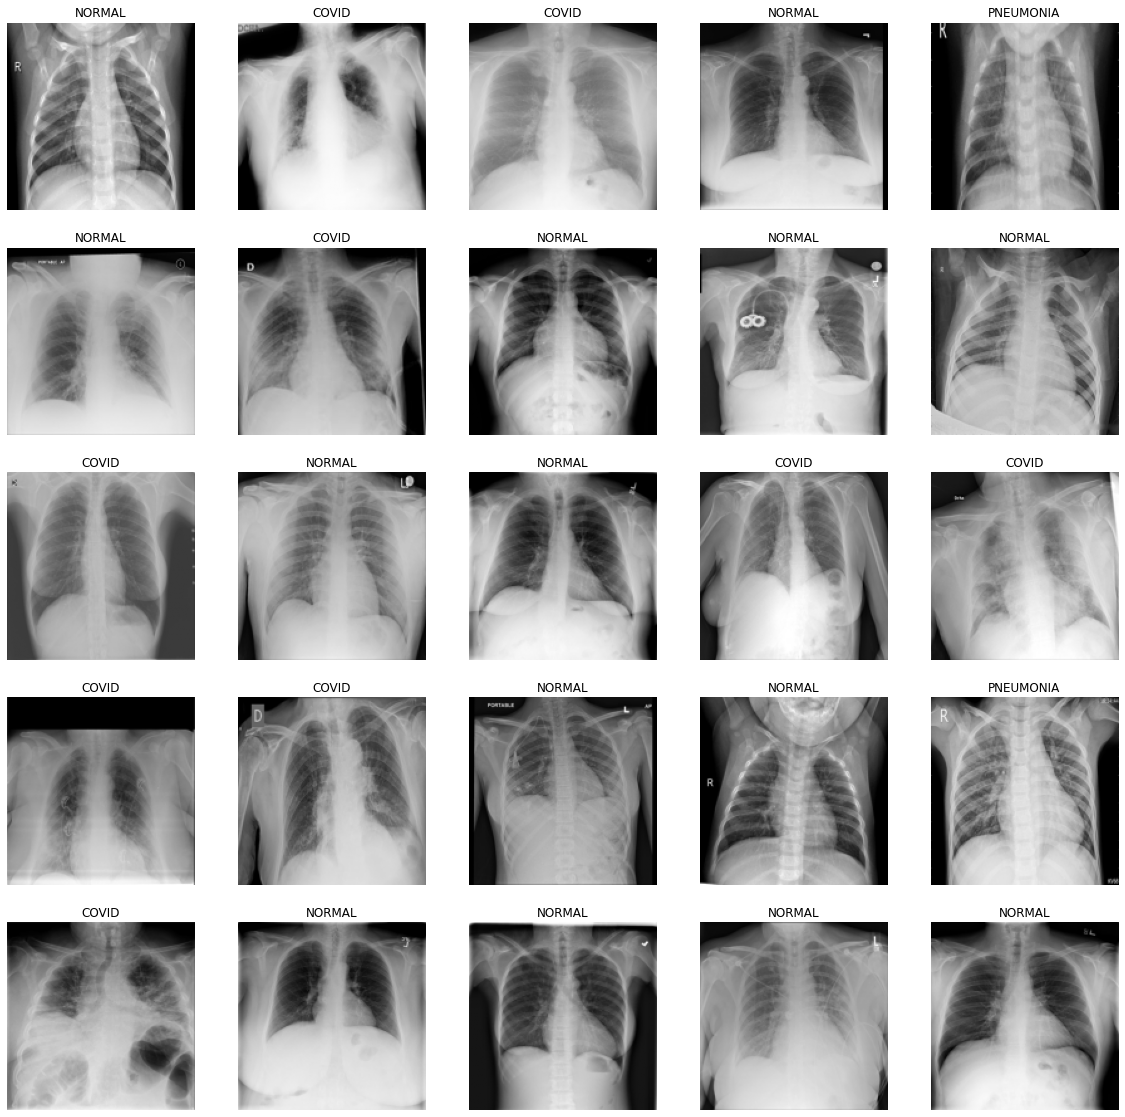

In [5]:
# Display 25 random images from all 3 categories

# Set size of image
plt.figure(figsize=(20,20))

# This for loop will iterate over random 25 images from the image path list
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) :
    
    # Plot the current image at subplot position n+1
    plt.subplot(5,5,n+1)
    
    # Access the image from Memory and plot with Gray colormap
    plt.imshow(Data[i] , cmap='gray')
    
    # Access label from Labels variable and add on current image
    plt.title(Labels[i])
    
    # Remove both x and y axis as they aren't required for this plotting
    plt.axis('off')

# Show the configured 25 images
plt.show()

# Transformation of the Data
The labels that we created are in categorical format, and the Neural Network that we want to use doesn't allow categorical inputs. Thus, we need to first perform One Hot Encoding on the labels to convert them into numerical format. 

In [6]:
# One Hot Encoding

# Initiate the Encoder from SKlearn
label_encoder = LabelEncoder()

# Encode Categorical values to Integer values
labels = label_encoder.fit_transform(Labels)
labels = to_categorical(labels)

We are a step closer to train our model but first we need to split our images and their labels into training and testing set.

In [7]:
# Garbage Collection for releasing Memory
gc.collect()

# Divide the Data and encoded labels into training and testing split Data
# The random state is kept as student number to make sure each time the random splitting is same
(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=20202926)

# Converting split data to array as tensorflow convolutional neural network needs array
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Printing tensor shape
# - First value for all the tensors is number of samples
# - Second and Third value for image data tensor is size of image
# - Last value for image data and Second value for label data tensor is dimension of tensor aka channel
print("Training image data tensor shape: ",x_train.shape,
      "\nTesting image data tensor shape: ",x_test.shape,
      "\nTraining image label tensor shape: ",y_train.shape,
      "\nTestig image label tensor shape: ",y_test.shape)

Training image data tensor shape:  (12122, 150, 150, 3) 
Testing image data tensor shape:  (3031, 150, 150, 3) 
Training image label tensor shape:  (12122, 3) 
Testig image label tensor shape:  (3031, 3)


# Model Definition
Let's define the CNN - Convolutional Neural Network model...

After doing classic trial and error, the following model with 3 Convolutional Layers with filter size of 32, 64 and 128 apperas to be providing highest accuracy.

In [8]:
# Defining Sequential Model from Keras
model = Sequential()

# Adding First 2D Convolutional Layer with kernel he_normal
# - he_normal draws samples from a truncated normal distribution centered on 0 
#   with stddev = sqrt(2 / number of input units in the weight tensor).

model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(resize,resize,3),
                 kernel_initializer='he_normal',))

# Adding 2D Max Pooling Layer for first Convolutional Layer
model.add(MaxPool2D(pool_size = (2,2)))

# Adding Second 2D Convolutional Layer
model.add(Conv2D(filters = 64, kernel_size =(3,3), activation = "relu"))
# Adding Second 2D Max Pooling Layer for second Convolutional Layer
model.add(MaxPool2D(pool_size = (2,2)))

# Adding Third 2D Convolutional Layer
model.add(Conv2D(filters = 128, kernel_size =(3,3), activation = "relu"))
# Adding Third 2D Max Pooling Layer for third Convolutional Layer
model.add(MaxPool2D(pool_size = (2,2)))

# Adding Second Dropout Layer to drop random network links
model.add(Dropout(0.25))

# Adding Flatten Layer for fully connected
# - Converting the 3D tensor into 2D tensor
model.add(Flatten())

# Adding First Dense Layer
model.add(Dense(64, activation = "relu"))

# Adding Second Dropout Layer to drop random network links
model.add(Dropout(0.2))

# Adding Third (Final/Output Ativation) Dense Layer
model.add(Dense(3, activation = "softmax"))

# Model Compilation
Here, we have selected Adam optimizer - a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [9]:
# Compiling the Sequential Model with Adam optimizer
model.compile(optimizer = adam(),loss= keras.losses.categorical_crossentropy,metrics= ['accuracy'])

# Printing model parameter details
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 128)       0

# Model Training
It's time for model training. We will also monitor the training time of the model.

In [10]:
gc.collect()
# Setting Epochs and Batch Size
# - Epochs = 20 => 20 iteration
# - Batch Size = 100 => Each epoch will have batch of 100
# - Verbose = 1 => Logs of model training will be printed while training the model
epochs = 20
batch_size = 100

# Defining Model Fitting Start Time
training_start_time = process_time()

# Model Fitting
CNN_MODEL = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Defining Model Fitting End Time
training_end_time = process_time()

# Finding Total Time taken for Model Fitting
training_total_time = training_end_time - training_start_time

# Printing Total Time taken for Model Fitting
print("Total time taken for Model Fitting: ",training_total_time," seconds")

Epoch 1/20
122/122 [==============================] - 32s 67ms/step - loss: 0.8868 - accuracy: 0.6873
Epoch 2/20
122/122 [==============================] - 8s 65ms/step - loss: 0.3097 - accuracy: 0.8752
Epoch 3/20
122/122 [==============================] - 8s 64ms/step - loss: 0.2363 - accuracy: 0.9105
Epoch 4/20
122/122 [==============================] - 8s 64ms/step - loss: 0.1937 - accuracy: 0.9275
Epoch 5/20
122/122 [==============================] - 8s 64ms/step - loss: 0.1612 - accuracy: 0.9406
Epoch 6/20
122/122 [==============================] - 8s 64ms/step - loss: 0.1333 - accuracy: 0.9501
Epoch 7/20
122/122 [==============================] - 8s 64ms/step - loss: 0.1233 - accuracy: 0.9536
Epoch 8/20
122/122 [==============================] - 8s 64ms/step - loss: 0.1073 - accuracy: 0.9589
Epoch 9/20
122/122 [==============================] - 8s 65ms/step - loss: 0.0889 - accuracy: 0.9678 0s - loss: 0.0887 - 
Epoch 10/20
122/122 [==============================] - 8s 65ms/step -

# Model Testing and Prediction
From the verbose output of the model training, we can see that the training accuracy is ~ 99%. This appears to be good, however, we are more interested in testing accuracy as it will provide us the measurement of how good our model is at understanding and classifying correct label for the unseen images that we kept from it as testing dataset.

In [11]:
# Identifying Loss and Accuracy of the model by Evaluation of the model using Test Data
# - Verbose = 0 => Logs of model Evaluation will not be printed
model_loss, model_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Printing the output of the evaluation/ Test Accuracy and Test Loss
print("Test Accuracy: ",model_accuracy,
      "\nTest Loss: ",model_loss)

# Defining class categories for prediction
class_categories = ['COVID-19','NORMAL','PNEUMONIA']

# Predicting the class of test data
y_pred = model.predict(x_test)

Test Accuracy:  0.9689871072769165 
Test Loss:  0.149356871843338


We can see that the testing accuracy all together is about 96.40% which is roughly 3% less than that of the training accuracy.

# Classification Report
Now the question is what is the individual accuracy of predicting the class labels? For example, suppose we wanted to know the training and/or testing accuracy of class COVID...

In [12]:
gc.collect()

# Generating classification report on training and testing data
predited_indices_x_train = model.predict (x_train, batch_size=batch_size)
predited_indices_x_train = np.argmax(predited_indices_x_train, axis=1)
predited_indices_x_test = model.predict(x_test, batch_size=batch_size)
predited_indices_x_test = np.argmax(predited_indices_x_test, axis=1)

print("Classification Report - Training:\n",
      classification_report(y_train.argmax(axis=1),predited_indices_x_train,
                            target_names=label_encoder.classes_, digits = 5),
      "\n\nClassification Report - Testing:\n",
      classification_report(y_test.argmax(axis=1), predited_indices_x_test,
                            target_names=label_encoder.classes_, digits = 5))

Classification Report - Training:
               precision    recall  f1-score   support

       COVID    0.99689   0.99585   0.99637      2893
      NORMAL    0.99865   0.99865   0.99865      8153
   PNEUMONIA    0.99722   1.00000   0.99861      1076

    accuracy                        0.99810     12122
   macro avg    0.99759   0.99817   0.99788     12122
weighted avg    0.99810   0.99810   0.99810     12122
 

Classification Report - Testing:
               precision    recall  f1-score   support

       COVID    0.96170   0.93776   0.94958       723
      NORMAL    0.97146   0.98480   0.97808      2039
   PNEUMONIA    0.96911   0.93309   0.95076       269

    accuracy                        0.96899      3031
   macro avg    0.96742   0.95188   0.95947      3031
weighted avg    0.96892   0.96899   0.96886      3031



From the f1 scores we can see that the training for all class is more than 99.8% in general, however, for testing COVID and Pneumonia shows significant drop than training.

To understand the consequences of this drop, let's visualize the class labels from the testing data... 

# Visualization of prediction using Confusion Matrix

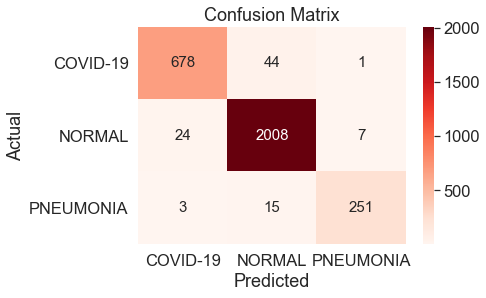

In [13]:
# Visualization of the Actual vs Predicted Data using Confusion Matrix

# Defining the a dataframe with test and predicted labels
conf_mat = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1)),
                        index=class_categories, columns=class_categories)

# Setting font size and color palette for the seaborn confustion matrix plot
sns.set(font_scale=1.5, color_codes=True, palette='deep')

# Creating Heatmap for confustion matrix
sns.heatmap(conf_mat, annot=True, annot_kws={'size':15}, fmt='d', cmap='Reds')

# Setting plot title, x-axis and y-axis labels
plt.title('Confusion Matrix')
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying confusion matrix plot
plt.show()

So for instance the intersection of Actual COVID-19 and Predicted Normal shows 55 data points which means that there were 55 patients who actually has COVID-19, however, the model predicted them as Normal. This can be fixed by either providing more images of patients with COVID-19 and tuning the hyperparameters of the model such that it doesn't learn the features very quickly.

# Model Saving and Memory Management

In [14]:
# Saving model for future use
model.save('PMM_MODEL.h5')

# Garbage collection for releasing Memory
gc.collect()

3906

# Grad CAM
The second part of this project is to visualize the identified COVID-19 Scar Tissue within the Chest X-Rays. Here, we have an algorithm called Gradiant-Weighted Class Activation Mapping or Grad CAM. This algorithm uses gradients of target concept in the final Convolutional Layer to produce localized map, highlighting the predicted portions of features in the image. The algorithm is readily available from Keras official git-hub repositor, and with some minor changes it is implemented here. [2]

In [15]:
def get_img_array(img_path, size):
    # img is a PIL image of size 150x150
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (150, 150, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 150, 150, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img_path, heatmap,alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Return Superimposed Image to Display
    return superimposed_img

Let's apply the Grad CAM algorithm on some randomly selected images from the dataset.

In [16]:
# Remove last layer's softmax
model.layers[-1].activation = None
last_conv_layer_name = "max_pooling2d_2"

img_paths = ['E:Radiography/COVID/COVID-1033.png','E:Radiography/COVID/COVID-1378.png',
             'E:Radiography/Normal/Normal-100.png','E:Radiography/Normal/Normal-10012.png']
img_size = (resize,resize)

fig = plt.figure(figsize=img_size)
rows = len(img_paths)
cols = 3

for i in range(0,rows*cols,3):
    
    img_path = img_paths[int(i/3)]
    
    # Prepare image
    img_array = get_img_array(img_path, size=img_size)

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Grad CAM output
    superimposed_img = display_gradcam(img_path, heatmap)

    # Actual Image
    actual_image = cv2.imread(img_path)
    
    # Actual Chest X-Ray Image
    fig.add_subplot(rows,cols,i+1)
    plt.axis("off")
    plt.imshow(actual_image)
    plt.title("")

    # Display heatmap
    fig.add_subplot(rows,cols,i+2)
    plt.axis("off")
    plt.imshow(heatmap)
    
    # Display Gradcam
    fig.add_subplot(rows,cols,i+3)
    plt.axis("off")
    plt.imshow(superimposed_img)

fig.tight_layout()
plt.show()

# Memory Management & Run Time Measurement

In [17]:
# Garbage collection for releasing Memory
gc.collect()

# Defining End Run Time
end_time = process_time()

# Total Run Time
total_time = end_time - start_time
print("Total Execution Time Taken: ",total_time," seconds")

Total Execution Time Taken:  376.234375  seconds


# References

[1] https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

[2] https://keras.io/examples/vision/grad_cam/ | https://github.com/keras-team/keras-io/blob/master/examples/vision/grad_cam.py